### Defining pytorch model 
* **Following pytorch model has one linear layer with `inputs`: 3 and `outputs`:1**
* **Kernel are initialized with He initialization**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            
        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

In [2]:
model, optimizer, loss= create_model()
model

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

#### Data preparation and scaling

        - Each record `X` cosist of first 3 values of 4 values
          from iris dataset input features.
        
        - 4th value serve as taget label `y` .

In [3]:
def scale(arr):
    f= lambda x: (x-np.mean(x))/np.var(x)
    for idx in range(arr.shape[1]):
        arr[:,idx]= f(arr[:, idx])
    #return arr
def plot(v1):
    plt.plot(v1)
    #plt.plot(v2)
    plt.title('Model training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.legend(['train', 'validation'], loc='upper right')
    return plt.show()

def samp(x, count):#For random batch generation
    idx= np.random.randint(x.shape[0], size=count)
    res = x[idx]
    return res

#### Model Training & plots

epoch:  0  loss:  6.13949728012085
epoch:  500  loss:  0.5693188309669495
epoch:  1000  loss:  0.3701828718185425
epoch:  1500  loss:  0.13028307259082794
epoch:  2000  loss:  0.13181103765964508
epoch:  2500  loss:  0.17847077548503876
epoch:  3000  loss:  0.07782946527004242
epoch:  3500  loss:  0.18391236662864685


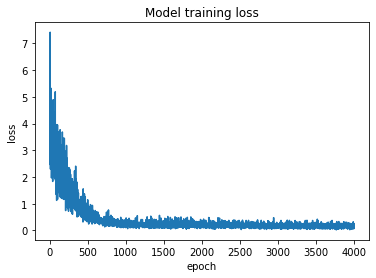

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, Y = data.data, data.target

Y[np.where(Y==2)[0]]=1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3)
scale(X)
scale(X_test)

#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression= list()
all_grads= list()
losses= list()
for epoch in range(4000):
    x_ =samp(X, count= 15)
    trainx= Variable(torch.Tensor(x_[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_[:,-1]).float(), (-1,1)))

    optimizer.zero_grad()
    y_pred = model(trainx)
    #print(y_pred)
    l = loss(y_pred, trainy)
    losses.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer.step()
all_wts_bias = np.array(wts_bias_progression).reshape(-1,4)
all_wts_bias_df= pd.DataFrame(all_wts_bias, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads = np.array(all_grads).reshape(-1,4)
all_grads_df= pd.DataFrame(all_grads, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses)

* **Following are the weights and bias for the ONLY layer in model, after 128 epochs**

In [5]:
li = list(model.parameters())
li

[Parameter containing:
 tensor([[ 0.1230, -0.0072,  1.8947]], requires_grad=True),
 Parameter containing:
 tensor([-0.0026], requires_grad=True)]

In [6]:
print('Final weights gradients : {}\nFinal bias gradients: {}'.format(li[0].grad, li[1].grad))

Final weights gradients : tensor([[ 0.4215, -0.2911,  0.1040]])
Final bias gradients: tensor([0.3149])


#### Gradients across epochs
* **Following are gradients(for weight- Beta_1-3 and bias-beta_4) updated after each epochs**

In [7]:
all_grads_df

,beta_1,beta_2,beta_3,beta_4
0,-4.294538,13.731360,-2.964942,2.179925
1,-1.847348,5.647979,-1.560173,0.810606
2,-3.244128,6.201935,-1.981886,1.601385
3,-2.851244,9.609488,-2.174966,-0.427073
4,-1.180106,6.985171,-1.273799,-0.321643
...,...,...,...,...
3995,-0.168011,0.177647,-0.190761,-0.049896
3996,0.042103,-0.188795,0.038514,0.285001
3997,0.293814,0.302496,-0.131233,-0.308035
3998,-0.242929,-0.757145,-0.154545,-0.083365


In [8]:
all_grads_df.describe()

,beta_1,beta_2,beta_3,beta_4
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.202807,0.789597,-0.270228,0.030992
std,0.659078,1.877172,0.414484,0.332724
min,-4.733401,-1.912172,-3.037025,-1.807045
25%,-0.310573,-0.169252,-0.297612,-0.150897
50%,-0.064038,0.177039,-0.144938,0.017246
75%,0.163339,0.784539,-0.043220,0.192044
max,0.957720,16.966837,0.342105,3.104012


### Defining model with statsmodel
* **Evaluating same data with linear regression from statsmodel**

In [9]:
import statsmodels.api as sm
feats, targets= X[:,:-1], X[:,-1]
feats= sm.add_constant(feats, prepend=False)

In [10]:
model_stm = sm.OLS(targets, feats, hasconst=True)
result= model_stm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        11:55:07   Log-Likelihood:                -45.701
No. Observations:                 150   AIC:                             99.40
Df Residuals:                     146   BIC:                             111.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2446      0.056     -4.363      0.0

* **Weights, biases and std_error from modelstats regression model**

In [11]:
summary= result.summary()
result.params

array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])

In [12]:
statsm_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])
statsm_df

,,coef,std err,t,P>|t|,[0.025,0.975]
0,x1,-0.2446,0.056,-4.363,0.000,-0.355,-0.134
1,x2,0.0729,0.016,4.553,0.000,0.041,0.104
2,x3,2.8110,0.131,21.399,0.000,2.551,3.071
3,const,9.368e-17,0.027,3.45e-15,1.000,-0.054,0.054


* **pytorch_params vs. statsmodel_params**

In [13]:
di = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads[-1,:], all_wts_bias[-1,:], result.params, statsm_df["std err"].values]))#all_grads
di

{'pytorch_grads': array([ 0.42154795, -0.29106644,  0.10396636,  0.31494987]),
 'pytorch_params': array([ 0.12320744, -0.00727499,  1.89435267, -0.00255189]),
 'statsmodel_params': array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17]),
 'statsmodel_stderr': array(['    0.056', '    0.016', '    0.131', '    0.027'], dtype=object)}

#### Paramters comparison

In [14]:
comp_df = pd.DataFrame(di)
comp_df

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr
0,0.421548,0.123207,-2.446118e-01,0.056
1,-0.291066,-0.007275,7.286124e-02,0.016
2,0.103966,1.894353,2.810966e+00,0.131
3,0.314950,-0.002552,9.367507e-17,0.027


#### Plots

In [15]:
def scatter_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.5
    max_x = max(list(x)+list(y)) + 0.5
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    ax.scatter(x, y, c="red")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=2)
    cb = fig.colorbar(hbin, ax=ax)
    cb.solids.set_edgecolor('face')#change colors
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

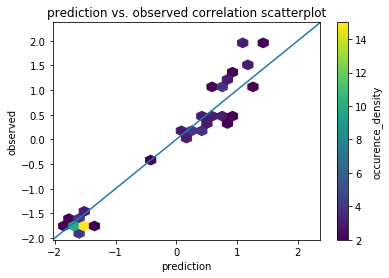

In [16]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

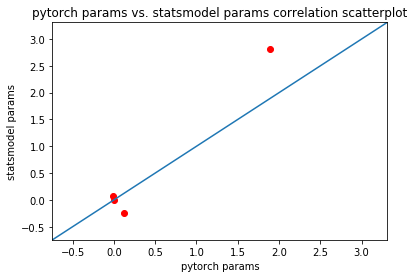

In [17]:
scatter_plot(comp_df['pytorch_params'].values,comp_df['statsmodel_params'].values, 'pytorch params' ,'statsmodel params')#n1,n2, 'abc','bcd')

### Calculating Standard error from pytorch model

In [18]:
mini_batches= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200
for batch in range(1, (len(all_grads))//mini_size):
    mini_batches.append(all_grads[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches.append(list(np.mean(mini_batches[-1], axis=0)))

grad_mini_batch_arr = np.array(mean_mini_batches).T
grad_mini_batch_arr.shape

(4, 19)

In [19]:
covariant_mat= np.cov(grad_mini_batch_arr)
covariant_mat

array([[ 0.13687628, -0.42405449,  0.09501638, -0.01876467],
       [-0.42405449,  1.32260645, -0.2960528 ,  0.05729   ],
       [ 0.09501638, -0.2960528 ,  0.06646359, -0.01292761],
       [-0.01876467,  0.05729   , -0.01292761,  0.0028305 ]])

In [20]:
pytorch_stderr= np.sqrt(covariant_mat.diagonal())#**2
pytorch_stderr

array([0.36996795, 1.15004628, 0.25780534, 0.05320245])

In [21]:
di.update({'pytorch_stderr':pytorch_stderr})
comp_df['pytorch_stderr']= pytorch_stderr
comp_df

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.421548,0.123207,-2.446118e-01,0.056,0.369968
1,-0.291066,-0.007275,7.286124e-02,0.016,1.150046
2,0.103966,1.894353,2.810966e+00,0.131,0.257805
3,0.314950,-0.002552,9.367507e-17,0.027,0.053202


### Experiments with configurations

#### Model with xavier normal kernel initialization

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model_2():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            torch.nn.init.xavier_normal_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model2, optimizer2, loss2= create_model_2()
model2

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

##### Model training and comparison plots

epoch:  0  loss:  2.0110695362091064
epoch:  500  loss:  0.4906547963619232
epoch:  1000  loss:  0.22976696491241455
epoch:  1500  loss:  0.3032104969024658
epoch:  2000  loss:  0.3274312913417816
epoch:  2500  loss:  0.2351997047662735
epoch:  3000  loss:  0.24066612124443054
epoch:  3500  loss:  0.17083239555358887


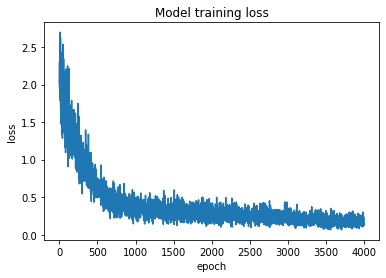

In [23]:
#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression_2= list()
all_grads_2= list()
losses_2= list()
for epoch in range(4000):
    x_transformed =samp(X, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer2.zero_grad()
    y_pred = model2(trainx)
    #print(y_pred)
    l = loss2(y_pred, trainy)
    losses_2.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model2.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_2.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads_2.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer2.step()
all_wts_bias_2 = np.array(wts_bias_progression_2).reshape(-1,4)
all_wts_bias_df_2= pd.DataFrame(all_wts_bias_2, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_2 = np.array(all_grads_2).reshape(-1,4)
all_grads_df_2= pd.DataFrame(all_grads_2, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_2)

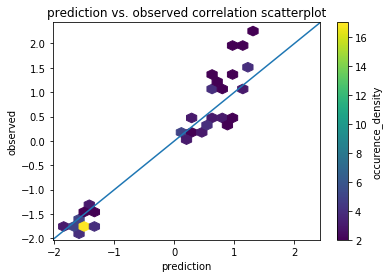

In [24]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model2(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison

* **Calculating standard error for pytorch model**

In [25]:
mini_batches_2= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_2= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_2))//mini_size):
    mini_batches_2.append(all_grads_2[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_2.append(list(np.mean(mini_batches_2[-1], axis=0)))

grad_mini_batch_arr_2 = np.array(mean_mini_batches_2).T
grad_mini_batch_arr_2.shape

(4, 19)

In [26]:
covariant_mat_2= np.cov(grad_mini_batch_arr_2)
pytorch_stderr_2= np.sqrt(covariant_mat_2.diagonal())
pytorch_stderr_2

array([0.46845245, 0.04304129, 0.2100927 , 0.17807524])

In [27]:
di_2 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_2[-1,:], all_wts_bias_2[-1,:], result.params, statsm_df["std err"].values]))
di_2.update({'pytorch_stderr':pytorch_stderr_2})
comp_df_2 = pd.DataFrame(di_2)
comp_df_2

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,-0.087530,0.226455,-2.446118e-01,0.056,0.468452
1,-0.003363,-0.023283,7.286124e-02,0.016,0.043041
2,-0.109649,1.631215,2.810966e+00,0.131,0.210093
3,-0.181720,0.003420,9.367507e-17,0.027,0.178075


#### Model with xavier_uniform kernel initialization

In [28]:
def create_model_3():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model3, optimizer3, loss3= create_model_3()
model3

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

##### Model training and comparison plots

epoch:  0  loss:  5.3236212730407715
epoch:  500  loss:  2.4891698360443115
epoch:  1000  loss:  0.7944655418395996
epoch:  1500  loss:  0.45041677355766296
epoch:  2000  loss:  0.6271871328353882
epoch:  2500  loss:  0.3169574439525604
epoch:  3000  loss:  0.44519269466400146
epoch:  3500  loss:  0.2581762671470642


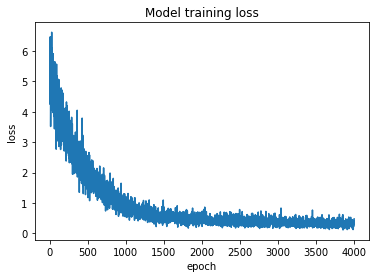

In [29]:
#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression_3= list()
all_grads_3= list()
losses_3= list()
for epoch in range(4000):
    x_transformed =samp(X, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer3.zero_grad()
    y_pred = model3(trainx)
    #print(y_pred)
    l = loss3(y_pred, trainy)
    losses_3.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model3.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_3.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads_3.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer3.step()
all_wts_bias_3 = np.array(wts_bias_progression_3).reshape(-1,4)
all_wts_bias_df_3= pd.DataFrame(all_wts_bias_3, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_3 = np.array(all_grads_3).reshape(-1,4)
all_grads_df_3= pd.DataFrame(all_grads_3, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_3)

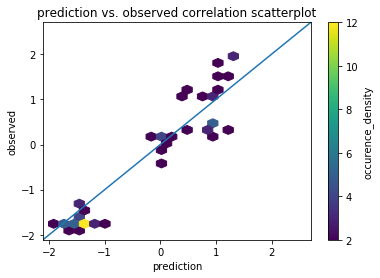

In [30]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model3(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [32]:
mini_batches_3= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_3= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_3))//mini_size):
    mini_batches_3.append(all_grads_3[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_3.append(list(np.mean(mini_batches_3[-1], axis=0)))

grad_mini_batch_arr_3 = np.array(mean_mini_batches_3).T
grad_mini_batch_arr_3.shape

(4, 19)

In [34]:
covariant_mat_3= np.cov(grad_mini_batch_arr_3)
pytorch_stderr_3= np.sqrt(covariant_mat_3.diagonal())
pytorch_stderr_3

array([1.11697111, 0.39883121, 0.49666469, 0.05750267])

In [35]:
di_3 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_3[-1,:], all_wts_bias_3[-1,:], result.params, statsm_df["std err"].values]))
di_3.update({'pytorch_stderr':pytorch_stderr_3})
comp_df_3 = pd.DataFrame(di_3)
comp_df_3

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.554924,0.609774,-2.446118e-01,0.056,1.116971
1,-0.018933,-0.096542,7.286124e-02,0.016,0.398831
2,-0.063888,0.698816,2.810966e+00,0.131,0.496665
3,-0.187836,0.001587,9.367507e-17,0.027,0.057503


#### Model training with different data scaling (MinMax)

In [36]:
from sklearn.preprocessing import MinMaxScaler

X, Y = data.data, data.target
sc= MinMaxScaler()
X_trans = sc.fit_transform(X)

Y[np.where(Y==2)[0]]=1
X_train, X_test, y_train, y_test = train_test_split(X_trans, Y, test_size= 0.3)

##### Model training and comparison plots

In [37]:
model4, optimizer4, loss4= create_model()#With default He Weights Initilizing model
model4

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

epoch:  0  loss:  0.33733275532722473
epoch:  500  loss:  0.05983152985572815
epoch:  1000  loss:  0.020931314677000046
epoch:  1500  loss:  0.013408646918833256
epoch:  2000  loss:  0.00894490722566843
epoch:  2500  loss:  0.009919128380715847
epoch:  3000  loss:  0.008731498382985592
epoch:  3500  loss:  0.009501343593001366


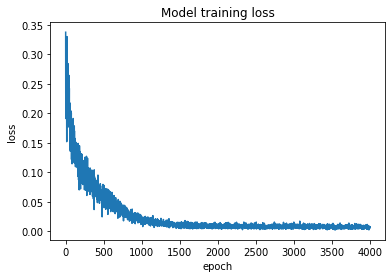

In [38]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))

wts_bias_progression_4= list()
all_grads_4= list()
losses_4= list()
for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer4.zero_grad()
    y_pred = model4(trainx)
    #print(y_pred)
    l = loss4(y_pred, trainy)
    losses_4.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model4.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_4.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_4.append(wts_bias_grads.tolist())#i_grads)
    optimizer4.step()

all_wts_bias_4 = np.array(wts_bias_progression_4).reshape(-1,4)
all_wts_bias_df_4= pd.DataFrame(all_wts_bias_4, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_4 = np.array(all_grads_4).reshape(-1,4)
all_grads_df_4= pd.DataFrame(all_grads_4, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_4)

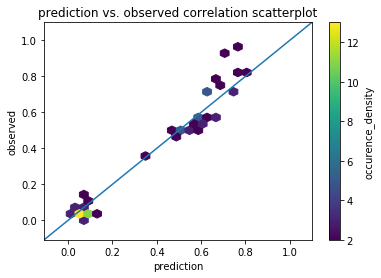

In [39]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model4(torch.Tensor(X_trans[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X_trans[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Retraining Statsmodel model with Scaled data

* **Evaluating same data with linear regression from statsmodel**

Statsmodel model Standard Error & Parameters Comparison

In [40]:
feats, targets= X_trans[:,:-1], X_trans[:,-1]
feats= sm.add_constant(feats, prepend=False)

model_stm_2 = sm.OLS(targets, feats, hasconst=True)
result_2= model_stm_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        11:58:34   Log-Likelihood:                 168.07
No. Observations:                 150   AIC:                            -328.1
Df Residuals:                     146   BIC:                            -316.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3109      0.071     -4.363      0.0

* **Weights, biases and std_error from modelstats regression model**

In [41]:
summary_2= result_2.summary()
result_2.params

array([-0.31089911,  0.22282854,  1.28837099, -0.10908804])

In [42]:
statsm_df_2 = pd.DataFrame(summary_2.tables[1].data[1:], columns=summary_2.tables[1].data[0])
statsm_df_2

,,coef,std err,t,P>|t|,[0.025,0.975]
0,x1,-0.3109,0.071,-4.363,0.000,-0.452,-0.170
1,x2,0.2228,0.049,4.553,0.000,0.126,0.320
2,x3,1.2884,0.060,21.399,0.000,1.169,1.407
3,const,-0.1091,0.027,-4.093,0.000,-0.162,-0.056


##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [44]:
mini_batches_4= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_4= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_4))//mini_size):
    mini_batches_4.append(all_grads_4[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_4.append(list(np.mean(mini_batches_4[-1], axis=0)))

grad_mini_batch_arr_4 = np.array(mean_mini_batches_4).T
grad_mini_batch_arr_4.shape

(4, 19)

In [45]:
covariant_mat_4= np.cov(grad_mini_batch_arr_4)
pytorch_stderr_4= np.sqrt(covariant_mat_4.diagonal())
pytorch_stderr_4

array([0.03206491, 0.01924692, 0.04832629, 0.0105358 ])

In [46]:
di_4 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_4[-1,:], all_wts_bias_4[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_4.update({'pytorch_stderr':pytorch_stderr_4})
comp_df_4 = pd.DataFrame(di_4)
comp_df_4

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.005942,0.026907,-0.310899,0.071,0.032065
1,-0.005724,0.040770,0.222829,0.049,0.019247
2,0.000604,0.986915,1.288371,0.060,0.048326
3,0.000012,-0.038455,-0.109088,0.027,0.010536


#### Model training with reference Weights from statsmodel

In [47]:
ref_kernel = torch.reshape(torch.Tensor(result_2.params[:-1]+ np.random.normal(0,0.1, result_2.params[:-1].shape[0])).float(), (1,-1))
ref_bias = result_2.params[-1] + 0.1#Adding noise

In [52]:
def create_model_5():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            self.fc1.weight= torch.nn.Parameter(ref_kernel)
            #torch.nn.init.constant_(ref_kernel,0.3)
            #self.fc1.weight.data= ref_kernel
            self.fc1.bias.data.fill_(ref_bias)
            #torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())#LBFGS(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model5, optimizer5, loss5= create_model_5()
model5

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

In [55]:
result_2.params#refrenced weights, bias from statsmodel

array([-0.31089911,  0.22282854,  1.28837099, -0.10908804])

In [56]:
list(model5.parameters())

[Parameter containing:
 tensor([[-0.4047,  0.1947,  1.1208]], requires_grad=True),
 Parameter containing:
 tensor([-0.0091], requires_grad=True)]

epoch:  0  loss:  0.007820341736078262
epoch:  500  loss:  0.005336611531674862
epoch:  1000  loss:  0.007394782733172178
epoch:  1500  loss:  0.003488107118755579
epoch:  2000  loss:  0.00621061073616147
epoch:  2500  loss:  0.009669643826782703
epoch:  3000  loss:  0.008191404864192009
epoch:  3500  loss:  0.003529761917889118


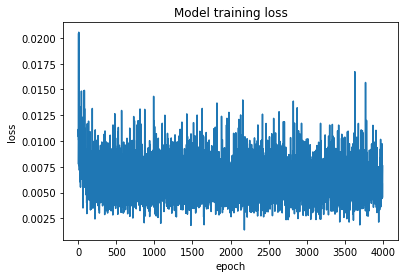

In [57]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))

wts_bias_progression_5= list()
all_grads_5= list()
losses_5= list()
for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer5.zero_grad()
    y_pred = model5(trainx)
    #print(y_pred)
    l = loss5(y_pred, trainy)
    losses_5.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model5.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_5.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_5.append(wts_bias_grads.tolist())#i_grads)
    optimizer5.step()

all_wts_bias_5 = np.array(wts_bias_progression_5).reshape(-1,4)
all_wts_bias_df_5= pd.DataFrame(all_wts_bias_5, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_5 = np.array(all_grads_5).reshape(-1,4)
all_grads_df_5= pd.DataFrame(all_grads_5, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_5)

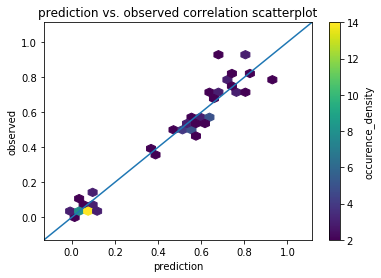

In [58]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model5(torch.Tensor(X_trans[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X_trans[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [59]:
mini_batches_5= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_5= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_5))//mini_size):
    mini_batches_5.append(all_grads_5[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_5.append(list(np.mean(mini_batches_5[-1], axis=0)))

grad_mini_batch_arr_5 = np.array(mean_mini_batches_5).T
grad_mini_batch_arr_5.shape

(4, 19)

In [60]:
covariant_mat_5= np.cov(grad_mini_batch_arr_5)
pytorch_stderr_5= np.sqrt(covariant_mat_5.diagonal())#**2
pytorch_stderr_5

array([0.0007938 , 0.00044358, 0.00070928, 0.00118473])

In [61]:
di_5 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_5[-1,:], all_wts_bias_5[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_5.update({'pytorch_stderr':pytorch_stderr_5})
comp_df_5 = pd.DataFrame(di_5)
comp_df_5

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,-0.026998,-0.303810,-0.310899,0.071,0.000794
1,-0.021806,0.220637,0.222829,0.049,0.000444
2,-0.035608,1.281873,1.288371,0.060,0.000709
3,-0.059698,-0.103755,-0.109088,0.027,0.001185


______________________